# **Pokémon Diffusion<a id="top"></a>**

> #### ``01-Dataset-Creation.ipynb``

<i><small>**Alumno:** Alejandro Pequeño Lizcano<br>Última actualización: 08/04/2024</small></i></div>

Este notebook tiene como objetivo el preprocesado de tanto las imágenes de Pokémon como de sus tipos para la posterior creación de un dataset que permita entrenar el modelo de difusión.

Para ello, ste notebook se dividirá en las siguientes secciones:

- [0. Imports](#-0.-Imports)

- [1. Carga de datos](#-1.-Carga-de-datos)

- [2. Preprocesamiento y creación del dataset](#-2.-Preprocesamiento-y-creación-del-dataset)

    - [2.1. Asignación de tipos a los Pokémon](#-2.1.-Asignación-de-tipos-a-los-Pokemón)
    - [2.2. Preprocesamiento y creación del dataset](#-2.2.-Preprocesamiento-y-creación-del-dataset)

# 0. Imports

Una vez introducido el proyecto, se importan las librerías necesarias para el desarrollo de este apartado.

---

In [1]:
# Import necessary libraries
# =====================================================================

# Import libraries for data preprocessing
import configparser
import pandas as pd
import random

# Import src code
from src.data.path_loader import PathLoader
from src.visualization import visualize
from src.data import create_dataset
from src.utils.utils import DATA_PATH, PROJECT_DIR

2024-04-08 17:30:36.114153: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-08 17:30:36.141612: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Set config file
# =====================================================================
config = configparser.ConfigParser()
config.read(PROJECT_DIR / "config.ini")

# Hyperparameters
config_hp = config["hyperparameters"]

IMG_SIZE = int(config_hp["img_size"])
BATCH_SIZE = int(config_hp["batch_size"])

# Carga de datos

Cargamos los datos a preprocesar que se usarán para crear el dataset para el modelo de difusión.

In [3]:
# Load csv data
# =====================================================================
path = f"{DATA_PATH}/processed/pokedex_cleaned.csv"
df = pd.read_csv(path)

# Show the df
df

,name,pokedex_id,type1,type2,image_fn
0,Bulbasaur,1,Grass,Poison,['1']
1,Ivysaur,2,Grass,Poison,['2']
2,Venusaur,3,Grass,Poison,['3']
3,Venusaur Gmax,3,Grass,Poison,['3_g']
4,Venusaur Mega,3,Grass,Poison,['3_2']
...,...,...,...,...,...
1113,Glastrier,896,Ice,NaN,['896']
1114,Spectrier,897,Ghost,NaN,['897']
1115,Calyrex,898,Psychic,Grass,['898_1']
1116,Calyrex Ice Rider,898,Psychic,Ice,['898_2']


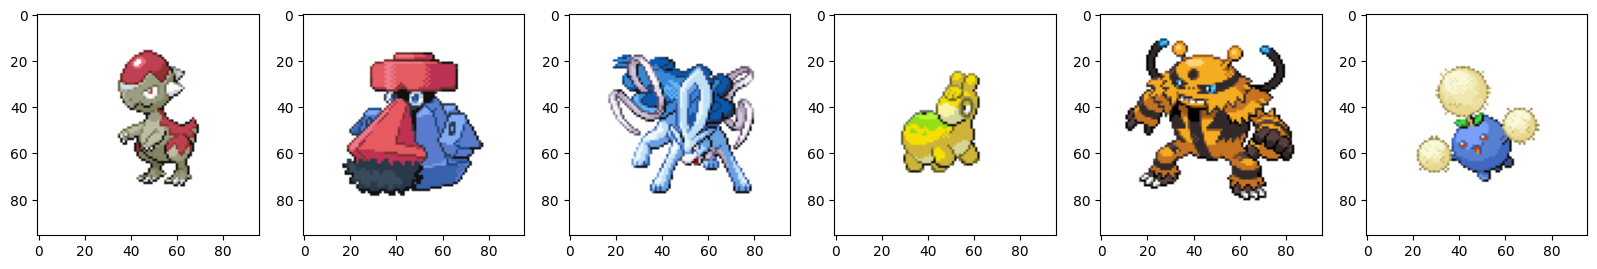

In [15]:
# Load json data paths
# =====================================================================
image_paths = PathLoader.get_image_paths(f"{DATA_PATH}/interim/image_paths.json")

# plot random images
visualize.plot_image_paths(image_paths, 6)

- Una vez cargados los datos seleccionados para el entrenamiento del modelo que se realizó en el anterior notebook, se procede a su preprocesado.

# 2. Preprocesamiento y creación del dataset

Se puede observar que los sprites de Pokémon necesitan un preprocesamiento que permita eliminar el fondo de los spries y así centrar la atención del modelo en el Pokémon en sí. Por ello, en la parte de preprocesado de los datos, se realizará un recorte del fondo de las imágenes. Con esto, se eliminará el ruido y se centrará la atención del modelo en el Pokémon en sí. Por otro lado, se necesita procesar las etiquetas para poder ser usadas en el modelo de difusión. Para ello, se codificarán las etiquetas en un formato one-hot encoding.

En este punto tenemos toda la información necesaria para poder crear el dataset de entrenamiento del modelo de difusión. Pues, por un lado tenemos la información de los Pokémon y por otro lado, tenemos las imágenes de los Pokémon (aunque estas últimas sean en path para ahorar tiempo de ejecución en este preprocesado).
    
Por tanto el preprocesado de las imágenes y etiquetas y la creación del dataset se realizará en los siguientes pasos:

- **Asignación de tipos a los Pokémon:** Es decir, asociar cada imagen con el tipo de Pokémon que representa. Esto permitirá tener ya un dataset, aunque este no esté preprocesado. Con esto se permite hacer cualquier otro tipo de procesamiento. En este dataset se guardará el path de la imagen y el tipo del Pokémon.

- **Preprocesado de datos:** Recorte del fondo de las imágenes para eliminar el ruido y centrar la atención del modelo en el Pokémon en sí y procesado de las etiquetas para poder ser usadas en el modelo de difusión, es decir, codificación de las etiquetas. Este proceso se realizará conjunto con la creación del dataset.

## 2.1 Asignación de tipos a los Pokémon

Para ello, usaremos la función `dataset_dict()` que dado el dataframe con los datos de los Pokémon y la lista de paths de los sprites, devuelve un diccionario con los datos ya asociados `{path: tipo}`. Posteriormente, se guardará este diccionario en un archivo `.json` para su posterior uso.

A la hora de hacer el preprocesamiento y crear el dataset, podremos usar directamente este diccionario o podemos prescindir de él y hacer el preprocesamiento directamente con el dataframe y la lista de paths de los sprites. Aunque interemediamente, la función que hace el preprocesamiento y creación del dataset, usará esta función si no se le pasa como argumento para hacer el preprocesamiento. Pero, como se ha explicado antes, se hace explicitamente este paso para poder a partir de este punto, hacer cualquier otro tipo de procesamiento y creación de dataset y para dividir el preprocesamiento en dos partes.

Dataset dictionary saved to file: /workspaces/tf-diffusion-scratch/data/interim/pokemon_dict_dataset.json with 8143 entries
- Number of images: 8143 
- Example data: ('/workspaces/tf-diffusion-scratch/data/raw/sprites/0612-Darkrai-491/front/shiny/491-gen4_hs.png', 'Dark') 
- Example data visualization: 


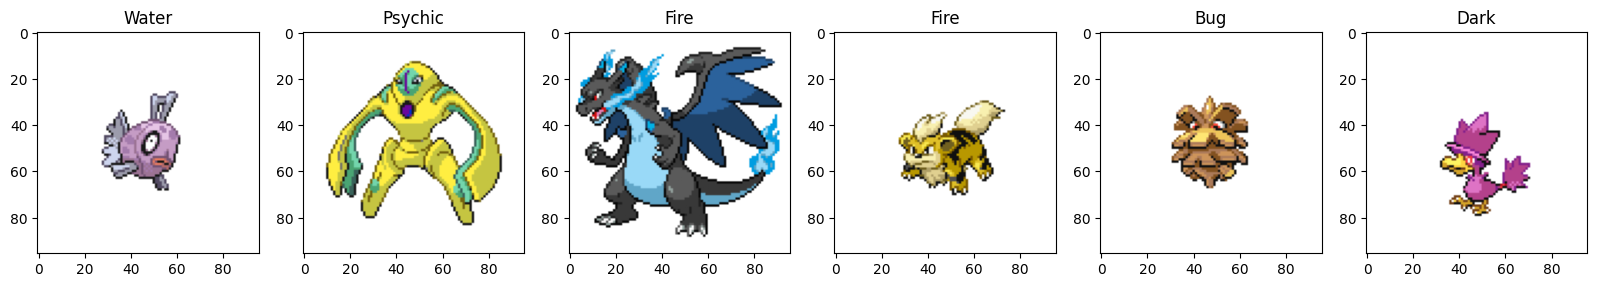

In [16]:
# Create a dictionary with the image paths as keys and the pokemon type as values
# =====================================================================
data_dict = create_dataset.dataset_dict(
    image_paths,
    df,
    save=True,
    save_path=f"{DATA_PATH}/interim/pokemon_dict_dataset.json",
)

# Check the data dictionary
# =====================================================================
print(
    f"- Number of images: {len(data_dict)} \n"
    f"- Example data: {random.choice(list(data_dict.items()))} \n"
    f"- Example data visualization: "
)

# plot random images with same type
visualize.plot_image_paths(data_dict, 6)

## 2.2 Preprocesamiento y creación del dataset

En el proceso de preprocesamiento de datos, implementamos cuatro etapas clave para preparar de manera eficiente y efectiva los datos para el entrenamiento del modelo generativo, estas etapas se llevan a cabo en la función de `dataset_tf()`:

- **Binarización de Etiquetas de Tipos de Pokémon**: Las etiquetas de los tipos de Pokémon se convierten en vectores binarios de 18 elementos. Cada elemento del vector representa un tipo de Pokémon. Esta conversión es crucial pues el modelo debe de procesar etiquetas nuúmericas no en formato texto.

- **Recorte de Imágenes**: Las imágenes se recortan para eliminar el fondo y centrar los sprites de los Pokémon. Esto se realiza para reducir el ruido y enfocar la atención del modelo en el Pokémon en sí. El proceso implica identificar el contorno del Pokémon (basándose en la diferencia de color con el fondo blanco) y recortar la imagen en función de este contorno.

- **Conversión y Escalado de Imágenes**: Las imágenes se convierten a tensores con `3 canales (RGB)` y se redimensionan a un tamaño uniforme de `(64x64x3)` píxeles. Esta uniformidad es esencial para garantizar un procesamiento consistente y eficiente durante el entrenamiento, y el tamaño elegido representa un equilibrio entre preservar detalles importantes y limitar la carga computacional.

- **Normalización de Píxeles**: Los valores de píxeles de las imágenes se normalizan desde el rango original `[0,255]` a `[-1,1]`. Esta normalización facilita un entrenamiento más estable y efectivo del modelo de difusión, pues los datos adecuadamente centrados y escalados pueden mejorar significativamente la eficiencia del aprendizaje.

Adicionalmente, los datos se estructuran en un formato `tf.data.Dataset`, que aplica el preprocesamiento descrito a través de las funciones `img_preprocess()` y `label_preprocess()`. La estructura del `tf.data.Dataset` se optimiza con técnicas como barajado (`shuffle`), memorización en caché (`cache`), agrupamiento en lotes (`batch`) y anticipación (`prefetch`), mejorando así la eficiencia del entrenamiento al gestionar de manera más efectiva la carga y preparación de los datos.

><span style="color: red; font-size: 1.5em;">&#9888;</span> <i><small>**NOTA:** La normalización de las imágenes en el rango `[-1,1]` se prefiere sobre `[0,1]` por varias razones:
>
>- **Centrado de Datos**: Normalizar a `[-1, 1]` centra los datos alrededor de cero, lo que puede mejorar la eficiencia del entrenamiento. Los pesos de la red aprenden más eficientemente con datos de entrada centrados.
>
>- **Mejor Distribución de los Gradientes**: Con los datos centrados, la distribución de los gradientes durante el entrenamiento tiende a ser más estable, lo cual es vital para un modelo generativo como el de difusión.
>
>- **Prevención de Saturación en la Activación**: En algunos casos, especialmente con funciones de activación que saturan, tener datos de entrada en un rango más amplio puede prevenir la saturación de la función de activación en las primeras etapas del entrenamiento, evitando así el entrenamiento lento o estancado.
>
></small></i>

In [17]:
dataset_path = f"{DATA_PATH}/processed/pokemon_tf_dataset"

# Create the dataset
# =====================================================================
dataset_tf = create_dataset.dataset_tf(
    image_paths=image_paths,
    df=df,
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    save=True,
    save_path=dataset_path,
)  # remember that you can also give the data_dict as input instead of the image_paths and df

2024-04-08 17:31:12.160322: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-08 17:31:12.164293: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-08 17:31:12.164413: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Dataset saved to file: /workspaces/tf-diffusion-scratch/data/processed/pokemon_tf_dataset


In [18]:
# Check the shape of the dataset
# =====================================================================
for img, label in dataset_tf.take(1):
    print(
        f"- The shape of the dataset data is: {img.shape} => batch_size: {img.shape[0]}, height: {img.shape[1]}, width: {img.shape[2]}, channels: {img.shape[3]}"
    )
    print(
        f"- The shape of the dataset labels is: {label.shape} => batch_size: {label.shape[0]}, number of labels: {label.shape[1]}"
    )

- The shape of the dataset data is: (64, 64, 64, 3) => batch_size: 64, height: 64, width: 64, channels: 3
- The shape of the dataset labels is: (64, 18) => batch_size: 64, number of labels: 18


2024-04-08 17:31:18.844996: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


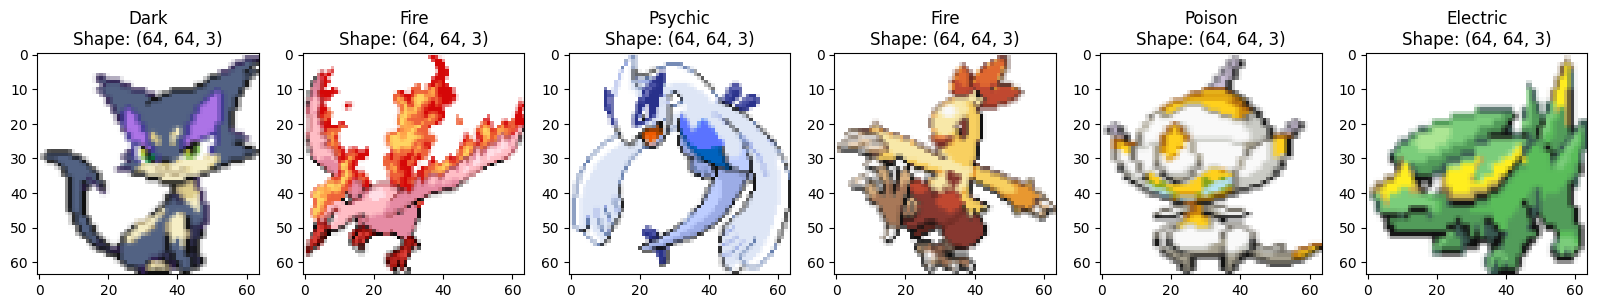

2024-04-08 17:32:16.930616: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [39]:
# Plot
# =====================================================================
visualize.plot_images_batch(dataset_tf, df, 6)

- Una vez preparado el dataset, podemos empezar a crear el modelo de difusión.

[BACK TO TOP](#top)